In [624]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
import pylab
from scipy.fftpack import rfft, irfft, fftfreq
import math
import matplotlib.pyplot as pp

%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 6)

In [625]:
%%capture
%load_ext sql

address = '127.0.0.1'
user = 'myadmin'
database = 'csciApp.db'

%sql sqlite:///$database

u'Connected: None@csciApp.db'

In [626]:
motionDevReset = """
DROP TABLE IF EXISTS MotionData_dev;
CREATE TABLE MotionData_dev (id INTEGER PRIMARY KEY AUTOINCREMENT, 
                             xAxis REAL, 
                             yAxis REAL, 
                             zAxis REAL,
                             timeStep REAL);
"""

In [658]:
### show label distribution
def plot_pulseDistribution(top,bot,merged):
    axes = pp.gca()
    axes.set_ylim([-1,1])
    fig = pp.gcf()
    fig.set_size_inches(12.0, 3.0)

    ar = np.arange(len(top))
    pp.plot(top, np.zeros_like(ar)+0.5, 'x')

    ar2 = np.arange(len(bot)) 
    pp.plot(bot, np.zeros_like(ar2)-0.5, 'x')
    
    ar3 = np.arange(len(merged)) 
    pp.plot(merged, np.zeros_like(ar3), 'x')
    
    pp.show()
    
def common_elements(list1, list2):
    result = []
    for element in list1:
        if element in list2:
            result.append(element)
    return result
    
def merge_arrays(array, array2):
    for i in range(0,len(array2)):
        array = find_nearest(array,array2[i],5)
    return common_elements(array2,array)

def merge_nearest(array):
    for i in range(0,len(array)):
        array = find_nearest(array,array[i],10)
    return np.unique(array)

def find_nearest(array,value,wsize):
    idx = (np.abs(array-value)<=wsize)
    array[idx] = value
    return array

outliers = 0.025
threshTop = 0.45
threshBot = -0.45
def findHeartRate(v, showPlot=False):
    dv = np.gradient(v)
    dv[dv>outliers] = outliers
    dv[dv<-outliers] = -outliers
    norm = np.array([float(d)/max(dv) for d in dv])
    
    pulses = norm.copy()
    pulses[pulses<threshBot] = -1
    pulses[pulses>threshTop] = 1
    pulses[abs(pulses)!=1] = 0
    
    top = np.where(pulses==1)[0]
    top = merge_nearest(top.copy())
    bot = np.where(pulses==-1)[0]
    bot = merge_nearest(bot.copy())
    intersect = merge_arrays(top.copy(),bot.copy())
    
    
    if showPlot:
        plt.subplot(221)
        plt.title("Raw Sensor Data")
        plt.plot(range(0,len(v)),v)
        plt.subplot(222)
        plt.title("Gradient of Sensor Data")
        plt.plot(range(0,len(dv)),dv)
        plt.subplot(223)
        plt.title("Normalized Gradient")
        plt.plot(range(0,len(norm)),norm)
        plt.subplot(224)
        plt.title("Thresholded")
        plt.plot(range(0,len(pulses)),pulses)
        plt.show()
        
    if showPlot:
        plot_pulseDistribution(top,bot,intersect)
    
    return len(top),  len(bot), len(intersect)

def displayHR(v):
    secs = len(v)*dt
    perMin = secs/60.0
    print "Sampling Frequency: {0} Hz, {1} seconds".format(1/dt,secs)
    tc,bc,ac = findHeartRate(v,showPlot=True)
    print "{0} Top BPM".format(tc/perMin)
    print "{0} Actual BPM".format(ac/perMin)
    print "{0} Bottom BPM".format(bc/perMin)

In [627]:
def filter_signal(sig,dt, showPlot=True):
    signal = sig.copy()
    N = len(signal)
    W = fftfreq(N, dt)
    
    f_signal = rfft(signal)
    cut_f_signal = f_signal.copy()
    ### 12-40 bpm = .2 - .67 HZ
    cut_f_signal[(W>.67)] = 0
    cut_f_signal[(W<0.2)] = 0
    freq = W[np.argmax(np.abs(cut_f_signal))]
    
    cut_signal = irfft(cut_f_signal)
    
    if showPlot:
        plt.subplot(221)
        plt.plot(range(0,len(signal)),signal)
        plt.subplot(222)
        plt.plot(W,f_signal)
        plt.subplot(223)
        plt.plot(W,cut_f_signal)
        plt.subplot(224)
        plt.plot(range(0,len(cut_signal)),cut_signal)
        plt.show()
        
    return freq

def displayBR(v):
    freq = filter_signal(v,dt)
    print "Detected Frequency: {0} Hz".format(freq)
    print "Breaths per minute: {0}".format(60.0*freq)

# Calculating Heartrate

In [668]:
### load data
results = %sql select * from MotionData_devHR
df = results.DataFrame()
### set time window
dt = df["timeStep"].mean()/1000.0

Done.


In [669]:
time = int(10.0/dt)
end = 2*time
start = 50 ## cut beginning for noise
while end < df.shape[0]:
    v = df["zAxis"][start:end].values
    secs = len(v)*dt
    perMin = secs/60.0
    tc,bc,ac = findHeartRate(v)
    print "{0} BPM".format(ac/perMin)
    start=end-time
    end+=time

70.7979446675 BPM
69.0402995665 BPM
69.0402995665 BPM


## Analysis over full dataset

Sampling Frequency: 100.758814005 Hz, 40.919497125 seconds


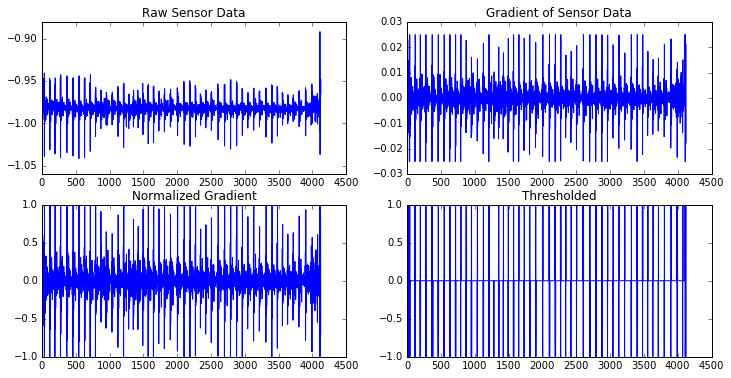

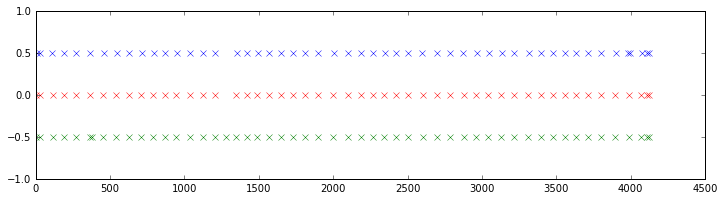

76.2472713305 Top BPM
74.7809776511 Actual BPM
77.7135650099 Bottom BPM


In [670]:
v = df["zAxis"].values
displayHR(v)

## Zoomed in to show Heart Rate Pulse Train

Sampling Frequency: 100.758814005 Hz, 3.50341559183 seconds


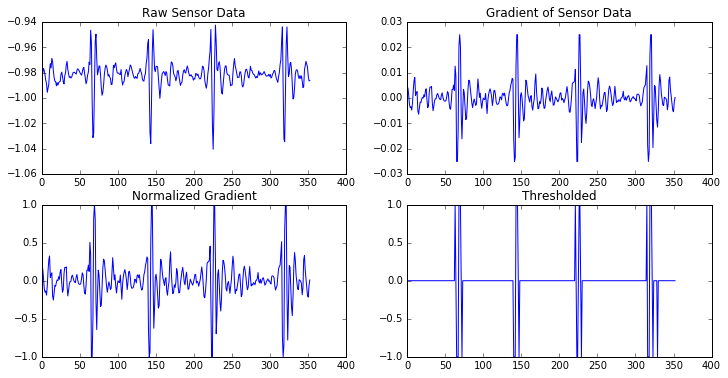

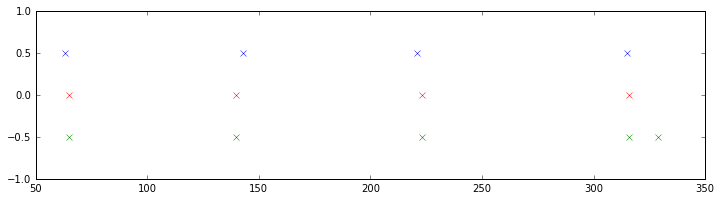

68.5045760941 Top BPM
68.5045760941 Actual BPM
85.6307201176 Bottom BPM


In [671]:
v = df["zAxis"][50:int(4.0/dt)].values
displayHR(v)

## Breathing Rate Analysis

In [628]:
### load data
results = %sql select * from MotionData_devBR
df = results.DataFrame()
### set time window
dt = df["timeStep"].mean()/1000.0

Done.


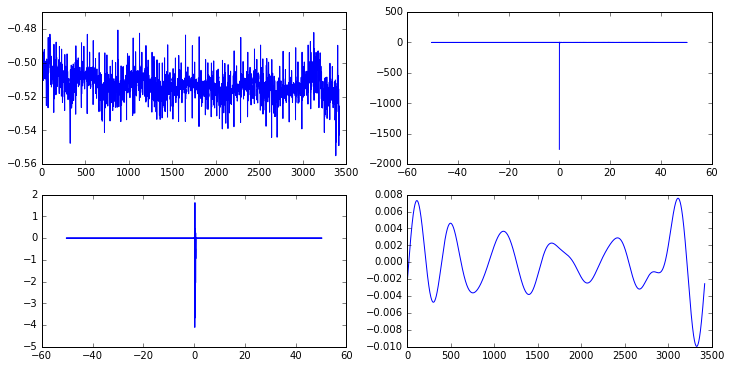

Detected Frequency: 0.265050728943 Hz
Breaths per minute: 15.9030437366


In [629]:
v = df["zAxis"].values
displayBR(v)